In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp

np.random.seed(29)

%run "./DiffusionLunarKF.ipynb"
%run "./CentralizedLunarKF.ipynb"
%run "./FilterComparison.ipynb"
%run "./VectorFormatting.ipynb"

[0.35430803867046085, 0.11686634647551015, 0.03004923545387446, 0.31307432785059, 0.4273645816325947, 0.5249535823408437, 0.7518419205946307, 0.9250310061639916]
[[0.18570205 0.35430804 0.11686635 0.03004924 0.31307433]
 [0.57263542 0.42736458 0.         0.         0.        ]
 [0.47504642 0.         0.52495358 0.         0.        ]
 [0.24815808 0.         0.         0.75184192 0.        ]
 [0.07496899 0.         0.         0.         0.92503101]]
Row Sums:  [1.0, 1.0, 1.0, 1.0, 1.0]


In [19]:
def sample_cov_and_mean(C):
    sample_cov = 0
    sample_mean = 0
    iters = 10 # monte carlo iters
    for j in range(iters):
      # Variables
      T_c = 0.00000009775
      f_L1 = 1575420000
      N_i = 4
      CN0 = 15
      B_pll = 0.5
      B_fe = 26000000
      T = 0.020
      d = 0.3
      pi = math.pi
      c = 299792458
      B_dll = 0.5
      dt = 7
      sigma_uere = 0 # can't find a value for this

      # Values from random table in Source 31
      # h_0 = 1.4*(10**(-22))
      # h_m1 = 2.3*(10**(-26))
      # h_m2 = 3.3*(10**(-31))

      # Values from sample clocks in Source 30
      h_0 = 1.8*(10**(-21))
      h_m1 = 6.492*(10**(-22))
      h_m2 = 1.37*(10**(-24))

      e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*h_m2*(pi**2)*(dt**3)
      e2 = 2*h_m1*dt + h_m2*((pi*dt)**2)
      e3 = ((h_0/(2*dt))+ 2*h_m1 + (8/3)*(pi*pi)*h_m2*dt)

      Q = (c**2)*np.array([[e1,e2],[e2,e3]])

      s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
      pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

      s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
      prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)

      R = lambda N : np.kron(np.eye(N),np.array([[pr_var,0],[0,prr_var]]))
      R_cf = lambda num_msmts: np.kron(np.eye(sum(num_msmts)),R(1))

      measure_noise = lambda num_msmts : np.linalg.cholesky(R_cf(num_msmts)) @ np.random.normal(
                                            np.array([[0 for _ in range(2*sum(num_msmts))]]).T)
      sigma_j = 10**(-16)

      # C = np.array([[0.3,0,0.2,0.5,0], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
      D = np.array([[3,3], [3, 3]])

      n = len(C)

      np.random.seed(j)

      true_biases = np.array([[np.random.normal(0,np.sqrt(12/(c**2))) for _ in range(n)]]).T
      true_drifts = np.array([[np.random.normal(0,np.sqrt(0.1/(c**2))) for _ in range(n)]]).T
      # true_drifts = np.array([[0 for _ in range(n)]]).T

      F = np.array([[1,dt],[0,1]])
      F_full = np.kron(np.eye(n),F)

      Q_10x10=np.kron(np.eye(n), Q)

      def get_station_truth(x,id):
        return np.array([[x[2*id][0]],[x[2*id+1][0]]])

      x = c*np.vstack(tuple([np.array([true_biases[i],true_drifts[i]]) for i in range(n)]))

      # Random initial estimates for each node
      x0 = [np.array([[np.random.normal(0,np.sqrt(12))],[np.random.normal(0,np.sqrt(0.1))]]) for i in range(n)]
      x0_cf = np.vstack(tuple(x0))
      # x0 = [np.array([[0],[0]]) for _ in range(n)]

      P = [100*np.copy(R(1)) for _ in range(n)]
      P_prev = np.block([[P[i] if i==j else np.zeros((2,2)) for j in range(n)] for i in range(n)])

      stations = [Station(i) for i in range(n)]

      filter_initialize(stations,D,x0,P)

      kf = KalmanFilter(A = F_full, H = H_cf, Q = Q_10x10, R = R_cf, P = P_prev, x0 = x0_cf)
      # For the first iteration these are our cross_links
      iterations = 150

      # num_msmts = np.random.randint(0,10,(iterations,5))
      num_msmts = np.array([[3,3] for _ in range(iterations)])
      filter_outputs = run_both_filters(iterations, num_msmts,C,F_full,stations,kf, x)

      errors_df,errors_cf,P_hist_cf,P_hist_df,truth,measurements,predictions_cf,predictions_df = filter_outputs

      # expectation of full state covariance (without normalizing)
      errors_flat = errors_df[-1].flatten()
      e = np.outer(errors_flat, errors_flat)
      sample_cov = sample_cov + e

      # expectation of errors
      sample_mean = sample_mean + errors_flat



    sample_cov = sample_cov / iters
    sample_mean = sample_mean / iters

    return sample_mean, sample_cov, P_hist_cf[-1]

In [20]:
def bhattacharyya_distance(mu1, mu2, Sigma1, Sigma2):
    term1 = 0.125 * np.dot((mu1 - mu2).T, np.linalg.inv((Sigma1 + Sigma2) / 2)).dot(mu1 - mu2)
    term2 = 0.5 * np.log(np.linalg.det((Sigma1 + Sigma2) / 2) / np.sqrt(np.linalg.det(Sigma1) * np.linalg.det(Sigma2)))
    return term1 + term2

1.795394889737333 0.28652570574855385


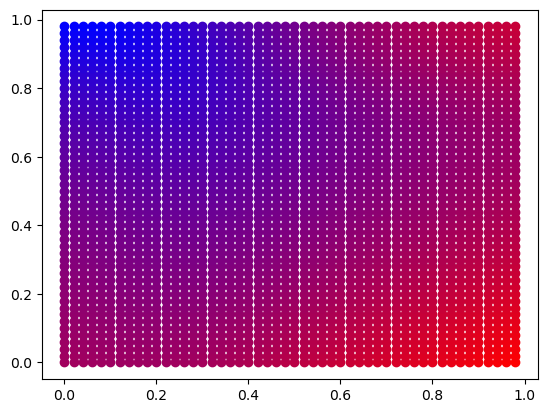

In [21]:
adj = np.array([[1,1],[1,1]])

points = []
max = 0
min = np.inf
progress = 0
for ten_x in range(0,50):
    for ten_y in range(0,50):
        print(progress/2500, end = "\r")
        progress+=1
        x = ten_x/50
        y = ten_y/50
        C = convert_to_adj([x,y],adj)
        dkf_mean, dkf_cov, kf_cov = sample_cov_and_mean(C)

        mu_kf = np.zeros(dkf_mean.shape)  # Mean of KF
        mu_df = dkf_mean  # Mean of DF
        Sigma_kf = kf_cov  # Covariance of KF
        Sigma_df = dkf_cov  # Covariance of DF
        dist = bhattacharyya_distance(mu_kf, mu_df, Sigma_kf, Sigma_df)
        points.append([x,y,dist])
        if dist < min:
            min = dist
        
        if dist>max:
            max = dist

color = lambda t: tuple([t,0,(1-t)])

for x,y,dist in points:
    norm_dist = (dist - min)/(max-min)
    plt.scatter(x,y,color = (norm_dist,0,1-norm_dist))
print(max,min)
plt.show()

